# Proyecto Final – Deep Learning  
## Modelo 2: Convolutional Neural Network (CNN)  
### Clasificacion de Tortugas de Agua vs Tortugas Terrestres

Para esta ocasion, la forma en que se considera si una tortuga es de agua o terrestre, es si su cuerpo esta adaptado para nadar/pasar muchas horas en el agua, pasa la mayor parte de su vida en agua, o caso contrario, si habitad es generalmente tierra o desierto donde no se sumerge. Dado a que si bien muchas especies pueden estar en diferentes entornos, siempre predomina si es mas "acuatica" o "de tierra".

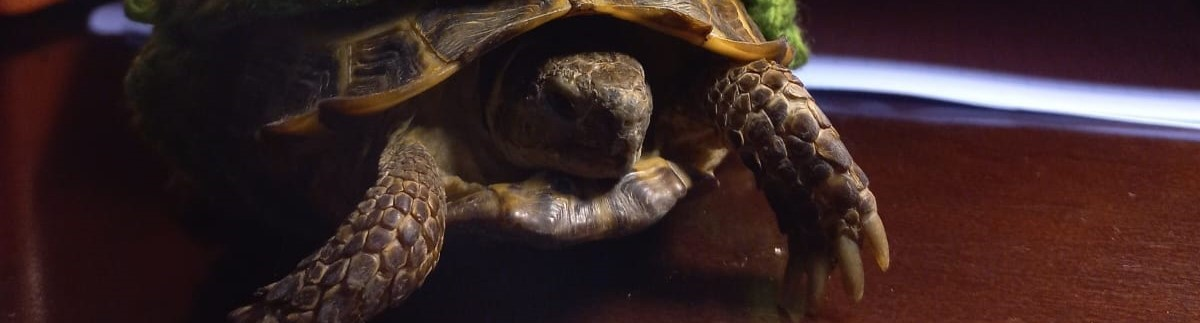

# ***Introducción y objetivo***

En esta parte del proyecto se implementa una **Convolutional Neural Network (CNN)** en PyTorch para resolver un problema de **clasificacion de imagenes de tortugas**.

El objetivo del modelo es clasificar cada imagen en una de dos categorias:

- `land`: tortugas terrestres o deserticas.
- `water`: tortugas acuaticas o marinas.

Este problema es un ejemplo de **vision por computadora** donde la red debe aprender a extraer caracteristicas visuales (formas, texturas, fondos, colores) para distinguir entre tortugas que viven principalmente en tierra y tortugas que viven en el agua.

Con esto se busca:

- aplicar una arquitectura **CNN** a un dataset realista (imagenes reales)
- entrenar y evaluar el modelo utilizando buenas practicas (train/val/test, data augmentation, scheduler, checkpoints)
- analizar los resultados y posibles mejoras del modelo.


In [8]:
!unzip trt_raw.zip -d .


Archive:  trt_raw.zip
   creating: ./trt_raw/
   creating: ./trt_raw/land/
  inflating: ./trt_raw/land/-como-es-la-tortuga-estrellada_.jpg  
  inflating: ./trt_raw/land/000aee0af66d4237.jpg  
  inflating: ./trt_raw/land/00ba381a304dd39d.jpg  
  inflating: ./trt_raw/land/00da0ea064179c85.jpg  
  inflating: ./trt_raw/land/00f5fa10fcb122fb.jpg  
  inflating: ./trt_raw/land/0128803D-BC28-49B7-AFD6-45E68D69A494.jpeg  
  inflating: ./trt_raw/land/01566320.jpg  
  inflating: ./trt_raw/land/0217050fc685f5a0.jpg  
  inflating: ./trt_raw/land/02fa5870d22986ed.jpg  
  inflating: ./trt_raw/land/0322.jpeg  
  inflating: ./trt_raw/land/06d3addcd3d6c577.jpg  
  inflating: ./trt_raw/land/06L0RZ5686UE.jpg  
  inflating: ./trt_raw/land/074ea6fffeaf11fd.jpg  
  inflating: ./trt_raw/land/085PX96TANQT.jpg  
  inflating: ./trt_raw/land/08bf008a5f5c8087.jpg  
  inflating: ./trt_raw/land/08LNHZS2T038.jpg  
  inflating: ./trt_raw/land/097cd9e82ea4c204.jpg  
  inflating: ./trt_raw/land/09c417df1f4a87ff.jpg  
  

estructurar data con split de 70% - 15% - 15%

# ***Descripción del dataset y EDA***


## Descripcion del dataset

Para este modelo se uso un conjunto de imagenes de tortugas reales de diferentes especies. A partir del zip original (`trt_raw.zip`), se organizo el siguiente esquema de carpetas:

- `trt_raw/`
  - `land/`: fotos de tortugas terrestres o deserticas.
  - `water/`: fotos de tortugas marinas o acuaticas.

Despues se creo una estructura final de dataset compatible con `torchvision.datasets.ImageFolder`:

```text
trt_dataset/
  train/
    land/
    water/
  val/
    land/
    water/
  test/
    land/
    water/


A demas, se dividieron las imagenes de cada clase de la siguiente forma:

- 70% para entrenamiento (train)
- 15% para validación (val)
- 15% para prueba (test)

Por ejemplo, en este caso:

land: total=600, train=420, val=90, test=90

water: total=600, train=420, val=90, test=90

Mas adelante se verifica el numero de imagenes en cada split usando ImageFolder y Counter, dandonos que se tiene entonces:

train: total=840, 420 land, 420 water

val: total=180, 90 land, 90 water

test: total=180, 90 land, 90 water

In [9]:
import os
import shutil
import random
from pathlib import Path

# carpeta original
orig_root = Path("trt_raw")

# carpeta destino
base = Path("trt_dataset")

classes = ["land", "water"]
splits = ["train", "val", "test"]
split_ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

# crear carpetas destino
for split in splits:
    for cls in classes:
        (base / split / cls).mkdir(parents=True, exist_ok=True)

# semilla
random.seed(42)

for cls in classes:
    images = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
        images.extend((orig_root / cls).glob(ext))

    images = list(images)
    random.shuffle(images)
    n_total = len(images)

    n_train = int(split_ratios["train"] * n_total)
    n_val = int(split_ratios["val"] * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    print(f"{cls}: total={n_total}, train={len(train_imgs)}, val={len(val_imgs)}, test={len(test_imgs)}")

    for split, split_imgs in [("train", train_imgs),
                              ("val", val_imgs),
                              ("test", test_imgs)]:
        for img_path in split_imgs:
            dest = base / split / cls / img_path.name
            shutil.copy2(img_path, dest)


land: total=600, train=420, val=90, test=90
water: total=600, train=420, val=90, test=90


# ***Preprocesamiento y data augmentation***

Para preparar las imagenes antes de ingresarlas a la red convolucional se utilizaron transformaciones diferentes para el conjunto de entrenamiento y para los conjuntos de validacion/prueba.

### Transformaciones para entrenamiento (data augmentation)

En el split de **entrenamiento** se aplican varias modificaciones de *data augmentation* con `torchvision.transforms`:

- `Resize((image_size, image_size))`: reescalado a un tamaño fijo
- `RandomHorizontalFlip(p=0.5)`: voltea horizontalmente la imagen con probabilidad 0.5
- `RandomRotation(10°)`: giros randoms
- `ColorJitter(brightness, contrast, saturation)`: variaciones de iluminacion y color
- `RandomResizedCrop(image_size, scale=(0.9, 1.0))`: recorte aleatorio con zoom
- `ToTensor()`: conversion a tensor
- `Normalize(mean, std)`: normalizacion con medias y desviaciones de ImageNet.

Estas transformaciones generan versiones diferentes de las imagenes en cada epoch ayudando a reducir el overfitting y a mejorar la generalizacion del modelo.

### Transformaciones para validacion y prueba

En los conjuntos de **validacion** y **prueba** se utilizan transformaciones mas simples:

- `Resize((image_size, image_size))`
- `ToTensor()`
- `Normalize(mean, std)`

De esta forma se evalua el modelo sobre imagenes mas generales y no alteradas tan brusca o aleatoriamente.

### Carga de datasets y DataLoaders

Finalmente se usa `datasets.ImageFolder` sobre las carpetas `train/`, `val/` y `test/`, y se construyen `DataLoader` con un `batch_size` de 32, activando `shuffle=True` unicamente en el conjunto de entrenamiento.


In [5]:
!pip install torch torchvision matplotlib scikit-learn


In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from pathlib import Path


Ahora procedemos a realizar data augmentation considerando:

*   RandomResizedCrop → zoom y recorte aleatorio
*   RandomHorizontalFlip → tortuga mirando izquierda/derecha
*   RandomRotation(15°) → pequeños giros
*   ColorJitter → variación de brillo/contraste/saturación





In [7]:
data_dir = Path("trt_dataset")

image_size = 224
batch_size = 32

# transformaciones con data augmentation para entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# validacion y test: solo resize + normalize (sin augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# datasets
train_dataset = datasets.ImageFolder(data_dir / "train", transform=train_transform)
val_dataset   = datasets.ImageFolder(data_dir / "val",   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(data_dir / "test",  transform=val_test_transform)

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("Clases:", class_names)


Clases: ['land', 'water']


# ***Visualización de datos (EDA visual)***

Para ver que las transformaciones se esten aplicando se visualizan algunas imagenes del conjunto de entrenamiento.

- Se toma un batch del `train_loader`.
- Se deshace la normalizacion para mostrar los colores originales aproximados.
- Se grafican varias imagenes junto con su etiqueta (`land` o `water`).

Esto para confirmar que las imagenes estan bien cargadas, que el *data augmentation* (rotaciones, flips, color jitter) se aplica como se espera y que las clases estan correctamente etiquetadas.


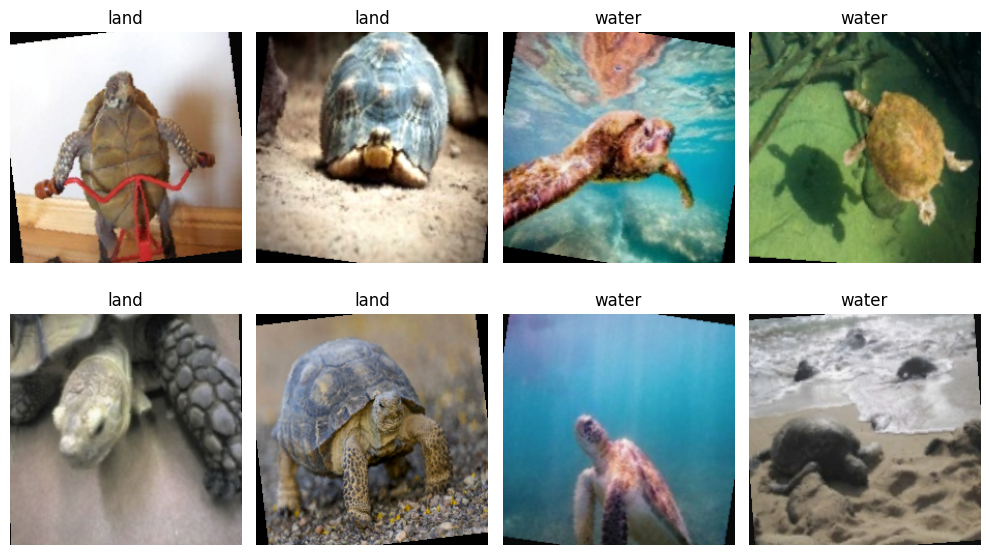

In [8]:
def imshow(img, title=None):
    # undo normalization para ver la imagen "normal"
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# mostrar un batch de entrenamiento (con augmentation aplicado)
inputs, labels = next(iter(train_loader))

plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(inputs[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


# ***Verificación de balance por clase***

Ademas de la exploracion visual se calcula el numero de imagenes por clase en cada split (`train`, `val`, `test`) utilizando `ImageFolder` y `Counter`.

Esto nos da que:

- `train`: 420 imagenes de `land` y 420 de `water`.
- `val`: 90 de `land` y 90 de `water`.
- `test`: 90 de `land` y 90 de `water`.

Esto es para ver que el dataset este balanceado en las dos clases para todos los subconjuntos.


In [9]:
from collections import Counter
from pathlib import Path

base = Path("trt_dataset")

for split in ["train", "val", "test"]:
    ds = datasets.ImageFolder(base / split, transform=val_test_transform)
    counts = Counter([ds.classes[label] for _, label in ds.samples])
    print(f"{split}: total={len(ds)} -", counts)


train: total=840 -> Counter({'land': 420, 'water': 420})
val: total=180 -> Counter({'land': 90, 'water': 90})
test: total=180 -> Counter({'land': 90, 'water': 90})


# ***seed para reproducibilidad***

Se fija una seed aleatoria (`seed = 42`) para `random`, `numpy` y `torch` para hacer los resultados reproducibles (misma division de datos, inicializacion de pesos, etc.).


In [10]:
import torch
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Definimos ahora la CNN

# ***Definicion del modelo (CNN)***

El modelo `TurtleCNN` es una red convolucional para clasificar imagenes de tortugas en dos clases (`land` y `water`).

La arquitectura se compone de:

1. **Extractor de caracteristicas (features)**  
   Tres bloques `Conv2d + BatchNorm2d + ReLU + MaxPool2d`:
   - incrementan la cantidad de canales (3, 32, 64, 128)
   - reducen progresivamente la resolucion espacial mediante `MaxPool2d(2)`
   - normalizan las activaciones con `BatchNorm2d` lo que estabiliza el entrenamiento

2. **Clasificador (classifier)**  
   Despues de aplanar (`Flatten`) se usa un MLP:
   - `Linear(..., 256)` + `ReLU()` + `Dropout(0.3)`
   - `Linear(256, 2)` para producir los logits de las dos clases

La funcion de activacion en las capas ocultas es ReLU y la salida se interpreta mediante `CrossEntropyLoss`.


In [11]:
class TurtleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(TurtleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (image_size // 8) * (image_size // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TurtleCNN(num_classes=2).to(device)
print(model)


TurtleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Drop

Definir loss, optimizer y loop de entrenamiento

# ***Entrenamiento del modelo***

### Funcion de perdida y optimizador

Para entrenar la CNN se utiliza:

- `nn.CrossEntropyLoss()` como funcion de perdida para clasificacion multiclase
- `Adam` como optimizador con `learning_rate = 1e-3`.

### Hiperparametros

- `num_epochs = 35`
- `batch_size = 32`
- `learning_rate = 1e-3`
- Uso de GPU (`cuda`)

### Scheduler de learning rate

Se usa `ReduceLROnPlateau` para reducir automaticamente el learning rate cuando la perdida de validacion deja de mejorar durante varias epoch (`patience=3`, `factor=0.5`).

En cada epoch se:

1. Entrena el modelo en el conjunto de `train`.
2. Evalua en el conjunto de `val`.
3. Registra `loss` y `accuracy` de train/val.
4. Actualiza el scheduler con `scheduler.step(epoch_val_loss)`.
5. Guarda el mejor modelo segun la menor `val_loss`.


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

num_epochs = 35

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float("inf")
best_model_path = "best_turtle_cnn.pth"

for epoch in range(num_epochs):
    # ---- entrenamient ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total

    # ---- validacion ----
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc = correct_val / total_val

    # llamamos al scheduler una vez por epoch
    scheduler.step(epoch_val_loss)

    # (ver el LR actual
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: lr = {current_lr:.6f}")

    # guardar historial
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    # guardar mejor modelo segun val_loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Epoch 1: lr = 0.001000
Epoch [1/35] Train Loss: 7.3378 Acc: 0.6690 | Val Loss: 1.0640 Acc: 0.7000
Epoch 2: lr = 0.001000
Epoch [2/35] Train Loss: 0.8631 Acc: 0.6988 | Val Loss: 0.6368 Acc: 0.7056
Epoch 3: lr = 0.001000
Epoch [3/35] Train Loss: 0.5359 Acc: 0.6976 | Val Loss: 0.5040 Acc: 0.7278
Epoch 4: lr = 0.001000
Epoch [4/35] Train Loss: 0.4726 Acc: 0.7500 | Val Loss: 0.4558 Acc: 0.7833
Epoch 5: lr = 0.001000
Epoch [5/35] Train Loss: 0.4507 Acc: 0.7548 | Val Loss: 0.4806 Acc: 0.7667
Epoch 6: lr = 0.001000
Epoch [6/35] Train Loss: 0.4439 Acc: 0.7643 | Val Loss: 0.4676 Acc: 0.7889
Epoch 7: lr = 0.001000
Epoch [7/35] Train Loss: 0.4298 Acc: 0.7845 | Val Loss: 0.4255 Acc: 0.8167
Epoch 8: lr = 0.001000
Epoch [8/35] Train Loss: 0.4372 Acc: 0.7845 | Val Loss: 0.4499 Acc: 0.7722
Epoch 9: lr = 0.001000
Epoch [9/35] Train Loss: 0.4468 Acc: 0.7833 | Val Loss: 0.5045 Acc: 0.7389
Epoch 10: lr = 0.001000
Epoch [10/35] Train Loss: 0.4450 Acc: 0.7798 | Val Loss: 0.4287 Acc: 0.7667
Epoch 11: lr = 0.0

# ***Curvas de entrenamiento***

Se grafican las curvas de:

- **Training vs Validation Loss**
- **Training vs Validation Accuracy**

En estas graficas se observa:

- La convergencia del modelo a lo largo de las epoch.
- La diferencia entre el rendimiento en entrenamiento y validacion, asi pudiendo detectar problemas de **overfitting** o **underfitting**.

Para este caso se observa:

- Una accuracy de entrenamiento que llega cerca de ~0.88.
- Una accuracy de validacion alrededor de ~0.81.

Lo que sugiere una ligera tendencia al overfitting pero aun con buena capacidad de generalizacion.


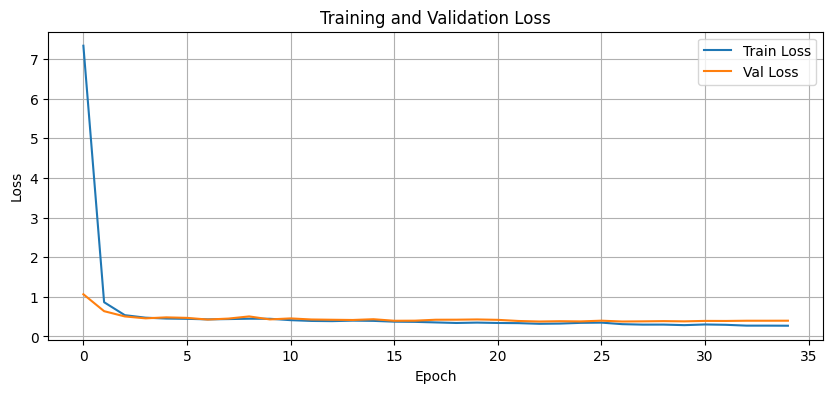

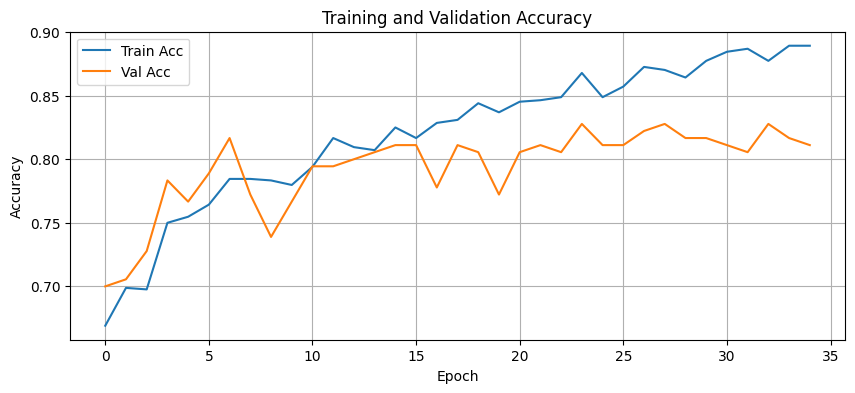

In [13]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Para este caso el modelo muestra una ligera diferencia entre el rendimiento en entrenamiento y validacion (aprox. 0.82 vs 0.75 de accuracy), lo que indica una tendencia moderada al overfitting. Sin embargo las metricas en el conjunto de prueba (accuracy ≈ 0.87, f1-score balanceado entre ambas clases) muestran que el modelo generaliza razonablemente bien en lo que cabe para las pruebas

Ya que se tiene la carga del modelo, se selecciona el mejor adecuado

# ***Evaluacion en el conjunto de prueba***

Una vez finalizado el entrenamiento se carga el mejor modelo segun la perdida de validacion y se evalua en el conjunto de prueba (`test`).

Con `classification_report` se obtuvo:

- **Accuracy en test** ≈ **0.86**
- Para ambas clases (`land`, `water`):
  - Precision ≈ 0.85–0.86
  - Recall ≈ 0.84–0.87
  - F1-score ≈ 0.85–0.86

Esto muestra que el modelo es capaz de distinguir de forma general entre tortugas terrestres y acuaticas, manteniendo un rendimiento balanceado entre ambas clases.


In [14]:
# cargar el mejor modelo
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
cm


              precision    recall  f1-score   support

        land       0.85      0.87      0.86        90
       water       0.86      0.84      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



array([[78, 12],
       [14, 76]])

Matriz de confusion

# ***Matriz de confusion***

Se muestra una matriz de confusion con las predicciones en el conjunto de prueba:

- Diagonal principal: ejemplos correctamente clasificados.
- Fuera de la diagonal: errores del modelo.

En este experimento, la matriz de confusión fue:

```text
[[78, 12],
 [14, 76]]


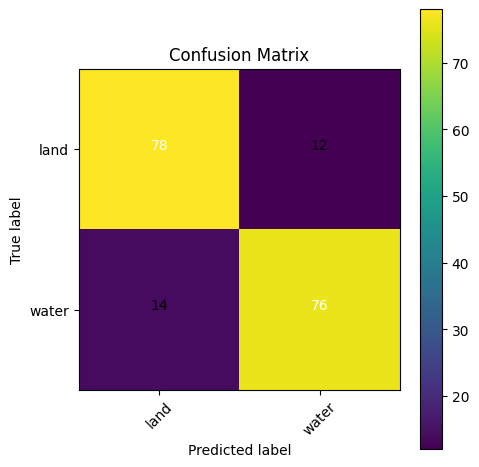

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()


Siguiendo con la documentacion, se muestran las predicciones correctas e incorrectas con su analisis de errores

# ***Ejemplos de predicciones y analisis de errores***

Para el analisis cuantitativo se visualizan varias imagenes del conjunto de prueba junto con:

- La etiqueta verdadera (`True: land` o `True: water`)
- La etiqueta predicha por el modelo (`Pred: ...`)

Al observar estos ejemplos se puede ver:

- Ver casos en los que el modelo acierta
- Analizar errores, por ejemplo:
  - Tortugas marinas en la orilla, donde el fondo se parece al de tortugas terrestres. En este caso no se observa, pero al momento de correr de nuevo el modelo se puede ver nuevamente
  - Imagenes con iluminacion complicada o con la tortuga muy pequeña o con mas objetos.

Este analisis cualitativo ayuda a entender mejor las limitaciones del modelo y posibles mejoras futuras.


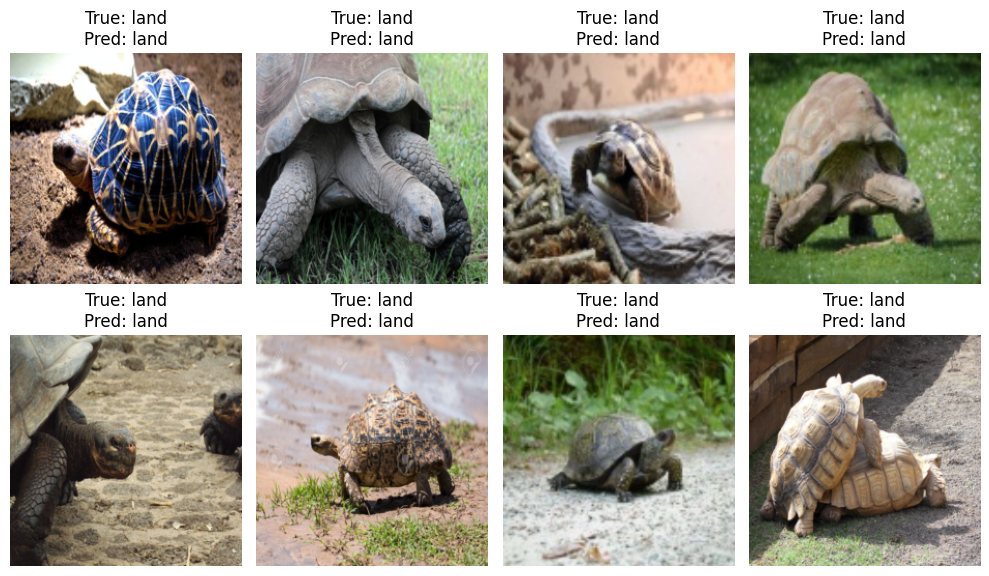

In [17]:
# un batch del test
data_iter = iter(test_loader)
images, labels = next(data_iter)

images_device = images.to(device)
outputs = model(images_device)
_, preds = outputs.max(1)
preds = preds.cpu()

plt.figure(figsize=(10, 6))
for i in range(min(8, len(images))):
    plt.subplot(2, 4, i+1)
    imshow(images[i], title=f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
plt.tight_layout()
plt.show()


# ***Analisis final y conclusiones***

### Interpretacion de resultados

El modelo CNN entrenado logra unresultados aceptables en la tarea de distinguir entre:

- Imagenes de tortugas **terrestres/deserticas** (`land`)
- Imagenes de tortugas **marinas/acuaticas** (`water`)

Considerando el limitado dataset

Con un accuracy en test ≈ 0.86 y metricas F1-score balanceadas entre ambas clases la red demuestra que ha aprendido caracteristicas visuales relevantes como formas, texturas y contexto.

Se observa una pequena diferencia entre el rendimiento en entrenamiento (~0.88) y validacion (~0.81), lo que indica una tendencia moderada al overfitting. Sin embargo la performance en el conjunto de prueba muestra que el modelo sigue generalizando razonablemente bien.

### Limitaciones

- el tamano del dataset es limitado y puede no cubrir toda la variabilidad posible de tortugas y entornos, dado que de estas existen muchisimas especies.
- hay casos ambiguos donde el contexto como arena, piedras o agua puede confundir al modelo.
- la arquitectura es relativamente sencilla comparada con modelos modernos de vision como ResNet, EfficientNet, etc.

### Posibles mejoras

1. aumentar el dataset con mas imagenes y mayor variedad de condiciones, o en dado caso, hacer mas clasificaciones y no solamente dos y luego generalizar
2. mejorar el data augmentation para encontrar un mejor equilibrio entre variedad y realismo
3. aplicar transfer learning usando un modelo preentrenado
4. probar mas regularizacion (Dropout, weight decay) para reducir un poco mas el overfitting

### Conclusion

El modelo de tortugas sirve como un buen ejemplo de aplicacion practica de redes convolucionales y como base para experimentar con arquitecturas y tecnicas mas avanzadas. Si bien aun se confunde un poco, se debe de considerar que se tiene una gran cantidad de especies con diferentes caracteristicas (como colores, tamanos, patrones, formas, patas y cabezas diferentes para las boscosas al compararlas con las deserticas, asi como las marinas se diferencias de las de pantanos y agua dulce) sin embargo, logra ejecutar la tarea de clasificar en su mayoria con todos los obstaculos.
